In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects


file_path = r"E:\Projects\Gamezone Orders Data\gamezone_orders_data_cleaned.csv"
df = pd.read_csv(
    file_path,
    parse_dates=['purchase_ts_cleaned', 'ship_ts'],
    dtype={
        'purchase_year': 'Int64',
        'purchase_month': 'Int64',
        'time_to_ship': 'Int64',
        'revenue': 'float'
    },
    encoding='utf-8',
    keep_default_na=False,
    na_values=['']  # Only treat empty strings as NaN
)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21864 entries, 0 to 21863
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   user_id                          21864 non-null  object        
 1   order_id                         21864 non-null  object        
 2   purchase_ts                      21864 non-null  object        
 3   purchase_ts_cleaned              21863 non-null  datetime64[ns]
 4   purchase_year                    21864 non-null  Int64         
 5   purchase_month                   21864 non-null  Int64         
 6   time_to_ship                     21864 non-null  Int64         
 7   ship_ts                          21864 non-null  datetime64[ns]
 8   product_name                     21864 non-null  object        
 9   product_name_cleaned             21864 non-null  object        
 10  product_id                       21864 non-null  object   

In [4]:
import pandas as pd
from collections import deque

# Prepare data
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])
df = df.sort_values('purchase_ts_cleaned')

# Create complete daily grid
date_range = pd.date_range(
    start=df['purchase_ts_cleaned'].min().floor('D'),
    end=df['purchase_ts_cleaned'].max().floor('D'),
    freq='D'
)

daily_users = (
    df.groupby(df['purchase_ts_cleaned'].dt.floor('D'))['user_id']
    .agg(lambda x: set(x))
    .reindex(date_range, fill_value=set())
    .reset_index()
    .rename(columns={'index': 'date', 'user_id': 'user_set'})
)

# Rolling 30-day MAB (optimized)
rolling_window = deque(maxlen=30)
mab_values = []

for user_set in daily_users['user_set']:
    rolling_window.append(user_set)
    
    if len(rolling_window) < 30:
        mab_values.append(None)
    else:
        mab_values.append(len(set().union(*rolling_window)))

daily_users['monthly_active_buyers'] = mab_values

# Extract date components
daily_users['year'] = daily_users['date'].dt.year
daily_users['month_num'] = daily_users['date'].dt.month
daily_users['month_name'] = daily_users['date'].dt.strftime('%b')

# Get month-end MAB values
monthly_mab = (
    daily_users[daily_users['monthly_active_buyers'].notna()]
    .groupby(['year', 'month_num', 'month_name'], as_index=False)  # Keep month_num
    .last()
    [['year', 'month_num', 'month_name', 'monthly_active_buyers']]  # Include month_num
    .sort_values(['year', 'month_num'])  # Now it exists!
)

# Optional: Drop month_num if you don't need it in output
# monthly_mab = monthly_mab.drop(columns=['month_num'])

print(monthly_mab)

    year  month_num month_name  monthly_active_buyers
0   2019          1        Jan                  399.0
1   2019          2        Feb                  345.0
2   2019          3        Mar                  503.0
3   2019          4        Apr                  530.0
4   2019          5        May                  487.0
5   2019          6        Jun                  474.0
6   2019          7        Jul                  484.0
7   2019          8        Aug                  502.0
8   2019          9        Sep                  577.0
9   2019         10        Oct                  473.0
10  2019         11        Nov                  604.0
11  2019         12        Dec                  650.0
12  2020          1        Jan                  290.0
13  2020          2        Feb                  671.0
14  2020          3        Mar                  955.0
15  2020          4        Apr                 1183.0
16  2020          5        May                 1191.0
17  2020          6        J

In [5]:
import pandas as pd

# Assuming df is your cleaned orders dataframe
# Ensure purchase_ts_cleaned is datetime
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])

# 1️⃣ Create a cohort column — first purchase month per user
first_purchase = (
    df.groupby('user_id')['purchase_ts_cleaned']
    .min()
    .dt.to_period('M')
    .rename('cohort')
)

df = df.join(first_purchase, on='user_id')

# 2️⃣ Count purchases per user
user_purchase_counts = df.groupby('user_id')['order_id'].nunique().rename('purchase_count')

# 3️⃣ Merge back with cohort info
user_data = df[['user_id', 'cohort']].drop_duplicates().merge(user_purchase_counts, on='user_id')

# 4️⃣ Calculate repeat purchase rate per cohort
rpr = (
    user_data.groupby('cohort')
    .apply(lambda x: (x['purchase_count'] >= 2).mean() * 100)
    .reset_index(name='repeat_purchase_rate_%')
)

# 5️⃣ Sort and clean for display
rpr['cohort'] = rpr['cohort'].astype(str)
rpr = rpr.sort_values('cohort').reset_index(drop=True)

print(rpr)


     cohort  repeat_purchase_rate_%
0   2019-01               14.797136
1   2019-02                5.345912
2   2019-03                4.280156
3   2019-04                4.406130
4   2019-05                3.434343
5   2019-06                3.640257
6   2019-07               13.078471
7   2019-08               11.284047
8   2019-09               19.366197
9   2019-10                5.010438
10  2019-11               14.020270
11  2019-12               19.908815
12  2020-01               12.631579
13  2020-02                3.291536
14  2020-03                2.564103
15  2020-04                3.889369
16  2020-05                2.350966
17  2020-06                3.187614
18  2020-07                7.714286
19  2020-08               10.488246
20  2020-09               16.025641
21  2020-10                3.093812
22  2020-11               10.157618
23  2020-12               19.304734
24  2021-01               31.241473
25  2021-02                0.240964


C:\Users\shaif\AppData\Local\Temp\ipykernel_6268\452118629.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x['purchase_count'] >= 2).mean() * 100)


In [6]:
# Save rpr DataFrame to Excel
rpr.to_excel("repeat_purchase_rate.xlsx", index=False)



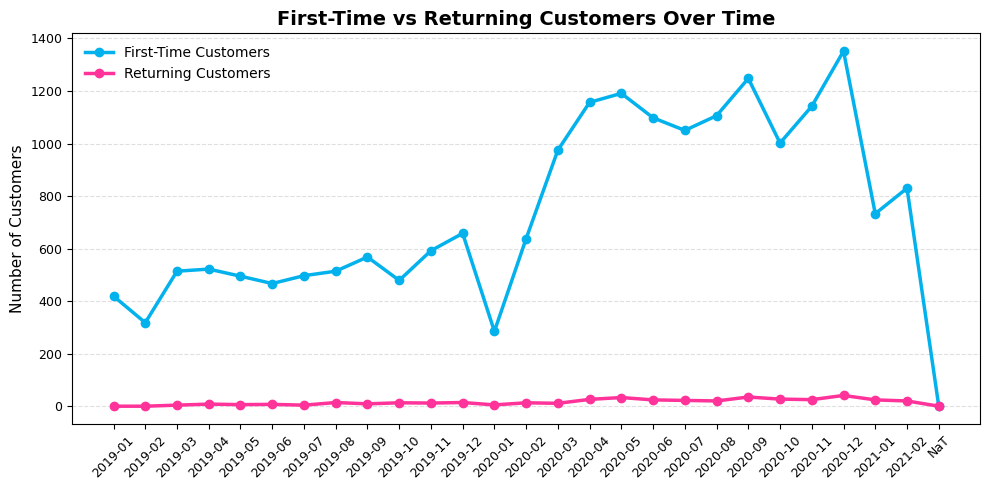

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure purchase date is datetime
df['purchase_ts_cleaned'] = pd.to_datetime(df['purchase_ts_cleaned'])

# Extract Year-Month for grouping
df['year_month'] = df['purchase_ts_cleaned'].dt.to_period('M').astype(str)

# Get each user's first purchase month
first_purchase = (
    df.groupby('user_id')['purchase_ts_cleaned']
    .min()
    .dt.to_period('M')
    .astype(str)
    .rename('first_purchase_month')
)
df = df.join(first_purchase, on='user_id')

# Label customers per order as 'New' or 'Returning'
df['customer_type'] = df.apply(
    lambda x: 'New' if x['year_month'] == x['first_purchase_month'] else 'Returning',
    axis=1
)

# Count unique users by type per month
customer_counts = (
    df.groupby(['year_month', 'customer_type'])['user_id']
    .nunique()
    .reset_index(name='customer_count')
)

# Pivot for line chart
pivot = customer_counts.pivot(index='year_month', columns='customer_type', values='customer_count').fillna(0)

# --- 🎨 Visualization ---
plt.figure(figsize=(10,5))
plt.plot(pivot.index, pivot['New'], color="#03b2ed", linewidth=2.5, marker='o', label='First-Time Customers')
plt.plot(pivot.index, pivot['Returning'], color="#FF3399", linewidth=2.5, marker='o', label='Returning Customers')

# Style tweaks
plt.title("First-Time vs Returning Customers Over Time", fontsize=14, weight='bold')
plt.xlabel("")
plt.ylabel("Number of Customers", fontsize=11)
plt.xticks(rotation=45, fontsize=9)
plt.yticks(fontsize=9)
plt.legend(frameon=False)
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


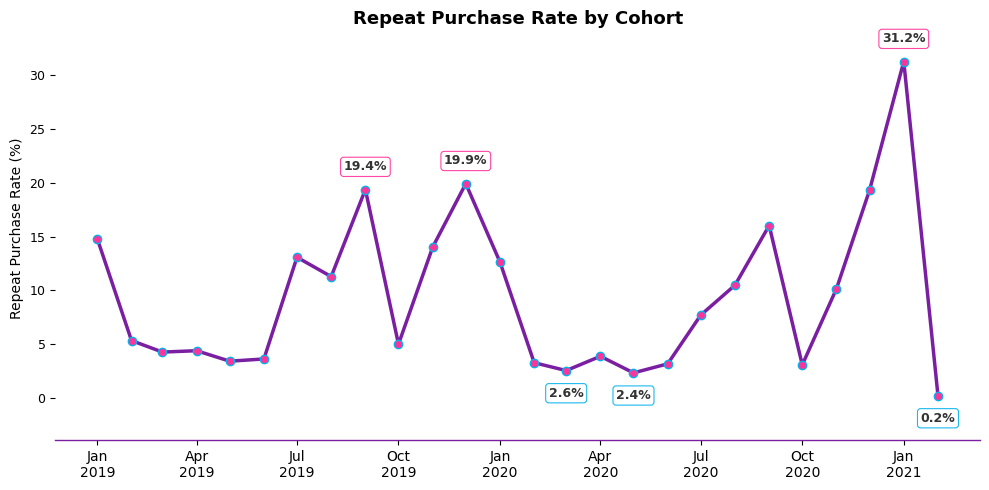

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime and sort
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify top 3 and bottom 3
top3 = rpr.nlargest(3, 'repeat_purchase_rate_%')
bottom3 = rpr.nsmallest(3, 'repeat_purchase_rate_%')

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

# Continuous line
ax.plot(
    rpr['cohort'],
    rpr['repeat_purchase_rate_%'],
    color="#7B1FA2",
    linewidth=2.5,
    marker='o',
    markerfacecolor="#FF3399",
    markeredgecolor="#03b2ed"
)

# --- Quarter-based ticks ---
quarter_ticks = rpr[rpr['cohort'].dt.month.isin([1, 4, 7, 10])]
ax.set_xticks(quarter_ticks['cohort'])
ax.set_xticklabels(
    [f"{m}\n{y}" for m, y in zip(
        quarter_ticks['cohort'].dt.strftime('%b'),
        quarter_ticks['cohort'].dt.strftime('%Y')
    )],
    fontsize=9
)

# --- Highlight labels ---
for _, row in top3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] + 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#FF3399", lw=0.8, alpha=0.9)
    )

for _, row in bottom3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] - 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='top',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#03b2ed", lw=0.8, alpha=0.9)
    )

# --- Styling ---
ax.set_title("Repeat Purchase Rate by Cohort", fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel("")
ax.set_ylabel("Repeat Purchase Rate (%)", fontsize=10)
ax.tick_params(axis='y', labelsize=9)
ax.grid(False)

# Hide outline
for spine in ax.spines.values():
    spine.set_visible(False)

# --- Lower the x-axis line (step below the chart) ---
ax.spines['bottom'].set_position(('outward', 20))  # moves x-axis 20px lower
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_color("#7B1FA2")
ax.spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.show()


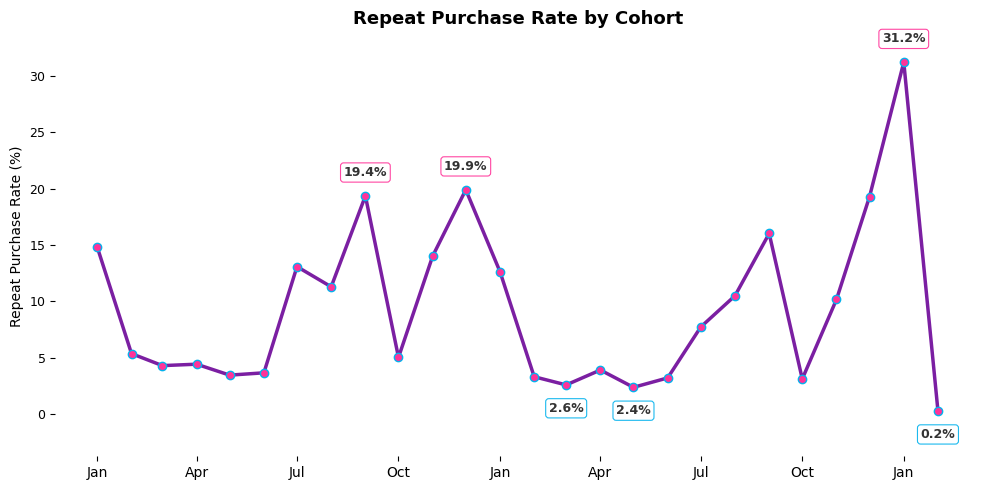

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure datetime and sort
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify top 3 and bottom 3
top3 = rpr.nlargest(3, 'repeat_purchase_rate_%')
bottom3 = rpr.nsmallest(3, 'repeat_purchase_rate_%')

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(10, 5), facecolor='white')

# Continuous line
ax.plot(
    rpr['cohort'],
    rpr['repeat_purchase_rate_%'],
    color="#7B1FA2",
    linewidth=2.5,
    marker='o',
    markerfacecolor="#FF3399",
    markeredgecolor="#03b2ed"
)

# --- Quarter-based ticks ---
quarter_ticks = rpr[rpr['cohort'].dt.month.isin([1, 4, 7, 10])]
ax.set_xticks(quarter_ticks['cohort'])
ax.set_xticklabels(
    [m for m in quarter_ticks['cohort'].dt.strftime('%b')],
    fontsize=9
)

# --- Highlight labels ---
for _, row in top3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] + 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#FF3399", lw=0.8, alpha=0.9)
    )

for _, row in bottom3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] - 1.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        va='top',
        fontsize=9,
        fontweight='bold',
        color="#333333",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#03b2ed", lw=0.8, alpha=0.9)
    )

# --- Styling ---
ax.set_title("Repeat Purchase Rate by Cohort", fontsize=13, fontweight='bold', pad=15)
ax.set_xlabel("")
ax.set_ylabel("Repeat Purchase Rate (%)", fontsize=10)
ax.tick_params(axis='y', labelsize=9)
ax.grid(False)

# Hide outline
for spine in ax.spines.values():
    spine.set_visible(False)

# --- Lower the x-axis line (step below the chart) ---
ax.spines['bottom'].set_position(('outward', 20))  # moves x-axis 20px lower
ax.spines['bottom'].set_visible(False)
ax.spines['bottom'].set_linewidth(1)

plt.tight_layout()
plt.show()


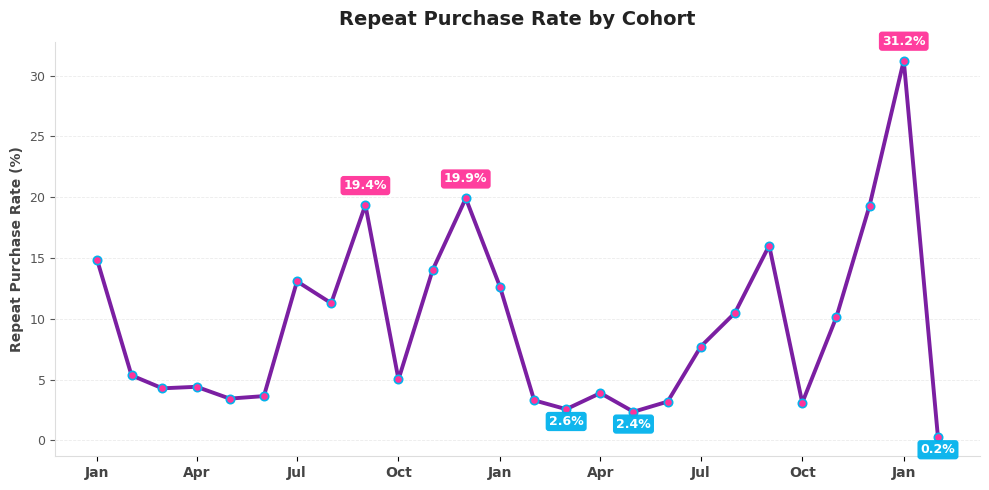

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify peaks & lows
top3 = rpr.nlargest(3, 'repeat_purchase_rate_%')
bottom3 = rpr.nsmallest(3, 'repeat_purchase_rate_%')

# Colors
purple = "#7B1FA2"
blue = "#03b2ed"
pink = "#FF3399"

# --- Plot Setup (Dashboard Style) ---
fig, ax = plt.subplots(figsize=(10, 5), facecolor="white")

ax.plot(
    rpr['cohort'],
    rpr['repeat_purchase_rate_%'],
    color=purple,
    linewidth=2.8,
    marker='o',
    markersize=6,
    markerfacecolor=pink,
    markeredgecolor=blue,
    markeredgewidth=1.2
)

# Quarter ticks only
quarter_ticks = rpr[rpr['cohort'].dt.month.isin([1, 4, 7, 10])]
ax.set_xticks(quarter_ticks['cohort'])
ax.set_xticklabels(
    quarter_ticks['cohort'].dt.strftime('%b'),
    fontsize=10,
    fontweight="bold",
    color="#444444"
)

# --- Y Axis (Dashboard Style) ---
ax.set_ylabel("Repeat Purchase Rate (%)", fontsize=10, fontweight="bold", color="#444444")
ax.tick_params(axis='y', labelsize=9, colors="#555555")
ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.25)

# Remove axis spines for clean card look
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)

ax.spines["left"].set_color("#DDDDDD")
ax.spines["bottom"].set_color("#DDDDDD")

# --- Highlight Top 3 ---
for _, row in top3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] + 1.3,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        fontsize=9,
        fontweight='bold',
        color="white",
        bbox=dict(
            boxstyle="round,pad=0.25",
            fc=pink,
            ec=pink,
            lw=0,
            alpha=0.95
        )
    )

# --- Highlight Bottom 3 ---
for _, row in bottom3.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] - 1.3,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        fontsize=9,
        fontweight='bold',
        color="white",
        bbox=dict(
            boxstyle="round,pad=0.25",
            fc=blue,
            ec=blue,
            lw=0,
            alpha=0.95
        )
    )

# Title
ax.set_title(
    "Repeat Purchase Rate by Cohort",
    fontsize=14,
    fontweight='bold',
    color="#222222",
    pad=12
)

plt.tight_layout()
plt.show()


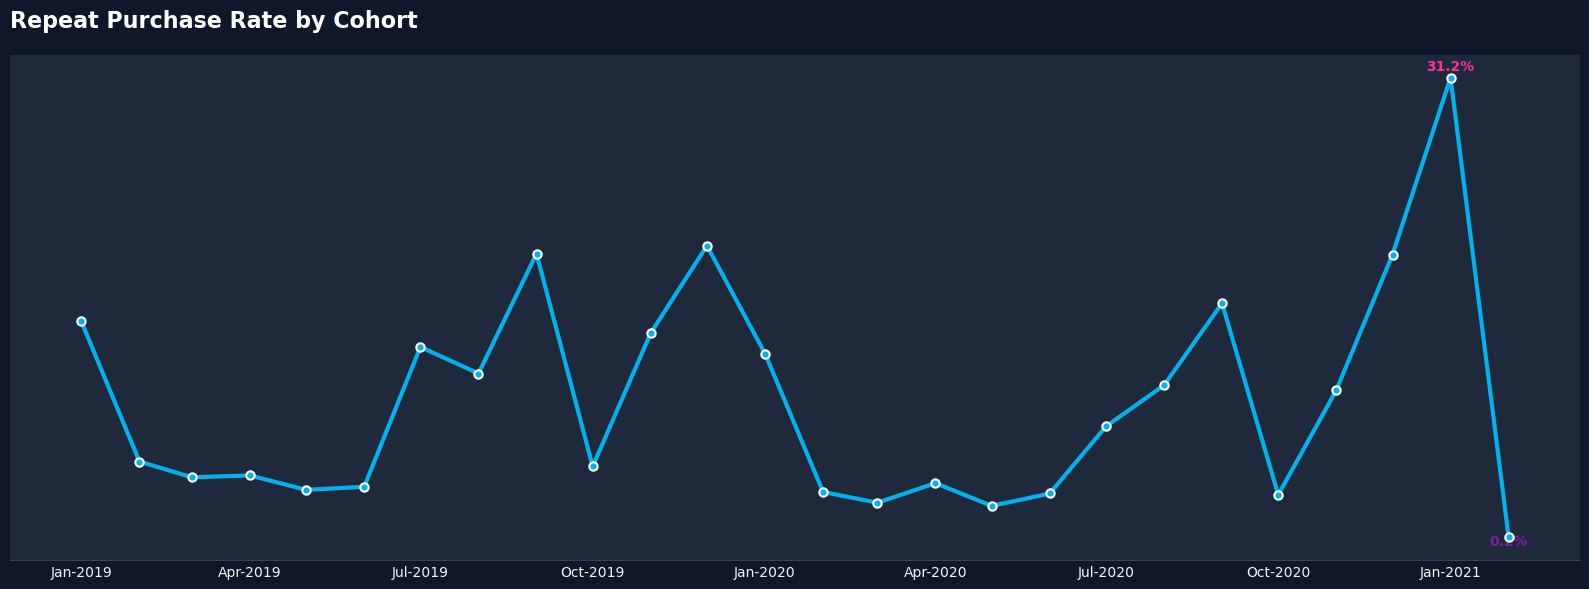

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify highest and lowest only
highest = rpr.nlargest(1, 'repeat_purchase_rate_%')
lowest = rpr.nsmallest(1, 'repeat_purchase_rate_%')

# Dashboard theme colors
PURPLE = "#7B1FA2"
BLUE = "#03b2ed"
PINK = "#FF3399"

# --- Plot Setup (Dark Dashboard Style) ---
fig, ax = plt.subplots(figsize=(16, 6))

# Backgrounds
fig.patch.set_facecolor('#0f172a')
ax.set_facecolor('#1e293b')

# Main line
ax.plot(
    rpr['cohort'],
    rpr['repeat_purchase_rate_%'],
    color=BLUE,
    linewidth=3,
    marker='o',
    markersize=6,
    markerfacecolor=BLUE,
    markeredgecolor="white",
    markeredgewidth=1.5,
    zorder=5
)

# Quarter ticks only
quarter_ticks = rpr[rpr['cohort'].dt.month.isin([1, 4, 7, 10])]
ax.set_xticks(quarter_ticks['cohort'])
ax.set_xticklabels(
    quarter_ticks['cohort'].dt.strftime('%b-%Y'),
    fontsize=10,
    color="#f1f5f9"
)
ax.tick_params(axis='x', length=0, color="#475569")

# --- Remove Y Axis ---
ax.set_yticks([])
ax.set_ylabel("")
ax.yaxis.set_visible(False)

# --- Minimal labels: only highest and lowest ---
for _, row in highest.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] + 0.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        fontsize=10,
        fontweight='bold',
        color=PINK
    )

for _, row in lowest.iterrows():
    ax.text(
        row['cohort'],
        row['repeat_purchase_rate_%'] - 0.5,
        f"{row['repeat_purchase_rate_%']:.1f}%",
        ha='center',
        fontsize=10,
        fontweight='bold',
        color=PURPLE
    )

# Remove all spines except bottom
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)

ax.spines["bottom"].set_linewidth(0.5)
ax.spines["bottom"].set_color("#475569")

# Title (dark theme)
ax.set_title(
    "Repeat Purchase Rate by Cohort",
    fontsize=16,
    fontweight='bold',
    color="white",
    pad=20,
    loc="left"
)

plt.tight_layout()
plt.show()

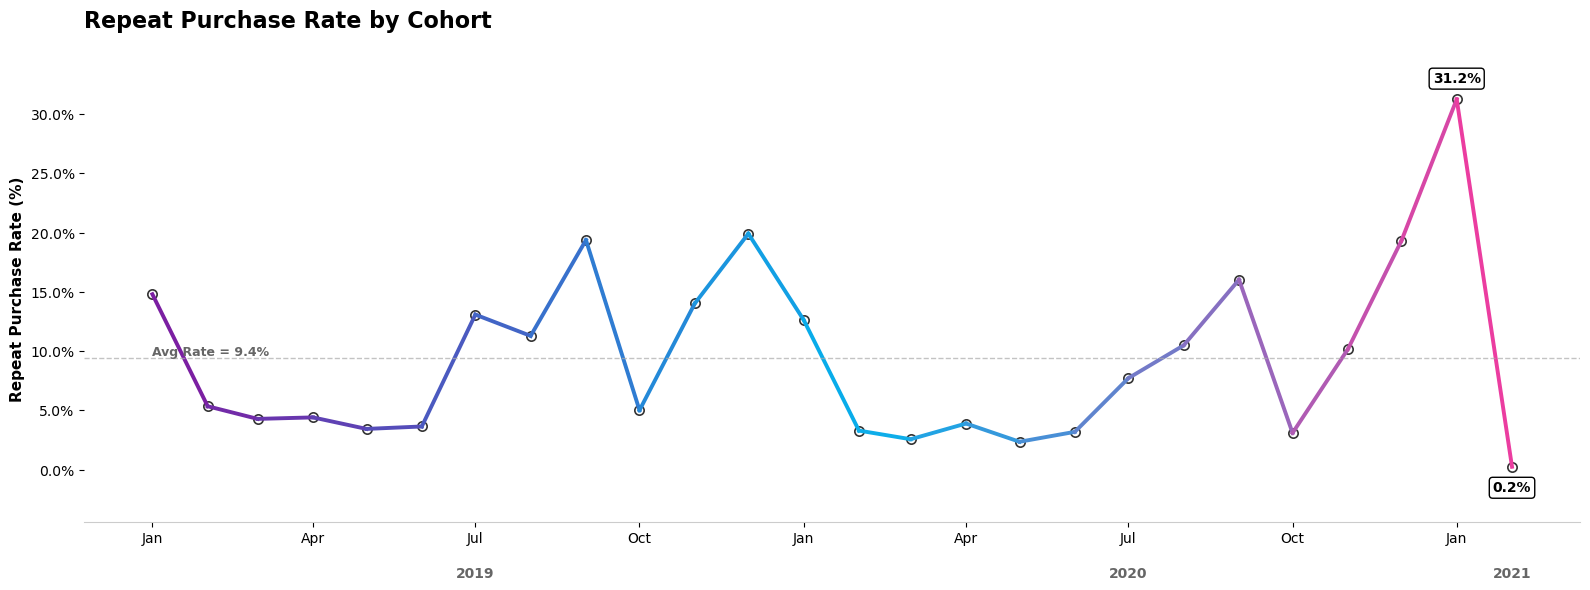

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Prepare data
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify highest and lowest only
highest = rpr.nlargest(1, 'repeat_purchase_rate_%')
lowest = rpr.nsmallest(1, 'repeat_purchase_rate_%')

# Your 3-color palette (Purple → Blue → Pink)
colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# Create gradient colormap for line
cmap = LinearSegmentedColormap.from_list("rpr_grad", colors)

# Normalize for gradient mapping
n = len(rpr)
gradient_colors = [cmap(i / (n - 1)) for i in range(n)]

fig, ax = plt.subplots(figsize=(16, 6))

# WHITE BACKGROUND
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# ---- GRADIENT LINE ----
for i in range(n - 1):
    ax.plot(
        rpr["cohort"].iloc[i:i+2],
        rpr["repeat_purchase_rate_%"].iloc[i:i+2],
        color=gradient_colors[i],
        linewidth=2.8
    )

# Markers
ax.scatter(
    rpr["cohort"],
    rpr["repeat_purchase_rate_%"],
    color="white",
    s=45,
    edgecolors="#333333",
    linewidth=1.2
)

# ---- TITLE ----
ax.set_title(
    "Repeat Purchase Rate by Cohort",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="#000000",
    pad=20
)

ax.set_xlabel("")

# ---- Y-AXIS (VISIBLE) ----
ax.set_ylabel("Repeat Purchase Rate (%)", color="#000000", fontsize=11, fontweight='bold')
ax.tick_params(axis="y", colors="#000000")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.1f}%'))

# ---- Quarter Ticks ----
quarter_mask = rpr["cohort"].dt.month.isin([1, 4, 7, 10])
quarter_data = rpr[quarter_mask]

plt.xticks(
    quarter_data["cohort"],
    quarter_data["cohort"].dt.strftime('%b'),
    fontsize=10,
    color="#000000"
)

# ---- Borders ----
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("#CCCCCC")

# ---- Y-range padding ----
ymin, ymax = rpr["repeat_purchase_rate_%"].min(), rpr["repeat_purchase_rate_%"].max()
ax.set_ylim(
    ymin - (ymax - ymin) * 0.15,
    ymax + (ymax - ymin) * 0.12
)

# ---- Avg Rate ----
avg_rate = rpr['repeat_purchase_rate_%'].mean()
ax.axhline(avg_rate, color="#AAAAAA", linestyle="--", linewidth=1, alpha=0.7)
ax.text(
    rpr['cohort'].iloc[0],
    avg_rate * 1.02,
    f"Avg Rate = {avg_rate:.1f}%",
    color="#666666",
    fontsize=9,
    fontweight="bold"
)

# ---- Highest & Lowest Labels ----
# Highest
for _, row in highest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# Lowest
for _, row in lowest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, -18),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# ---- Year labels below chart ----
years = rpr["cohort"].dt.year.unique()
for yr in years:
    yd = rpr[rpr['cohort'].dt.year == yr]
    mid_month = yd["cohort"].iloc[len(yd)//2]
    ax.text(
        mid_month,
        ymin - (ymax - ymin) * 0.30,
        str(yr),
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#666666"
    )

plt.tight_layout()
plt.show()

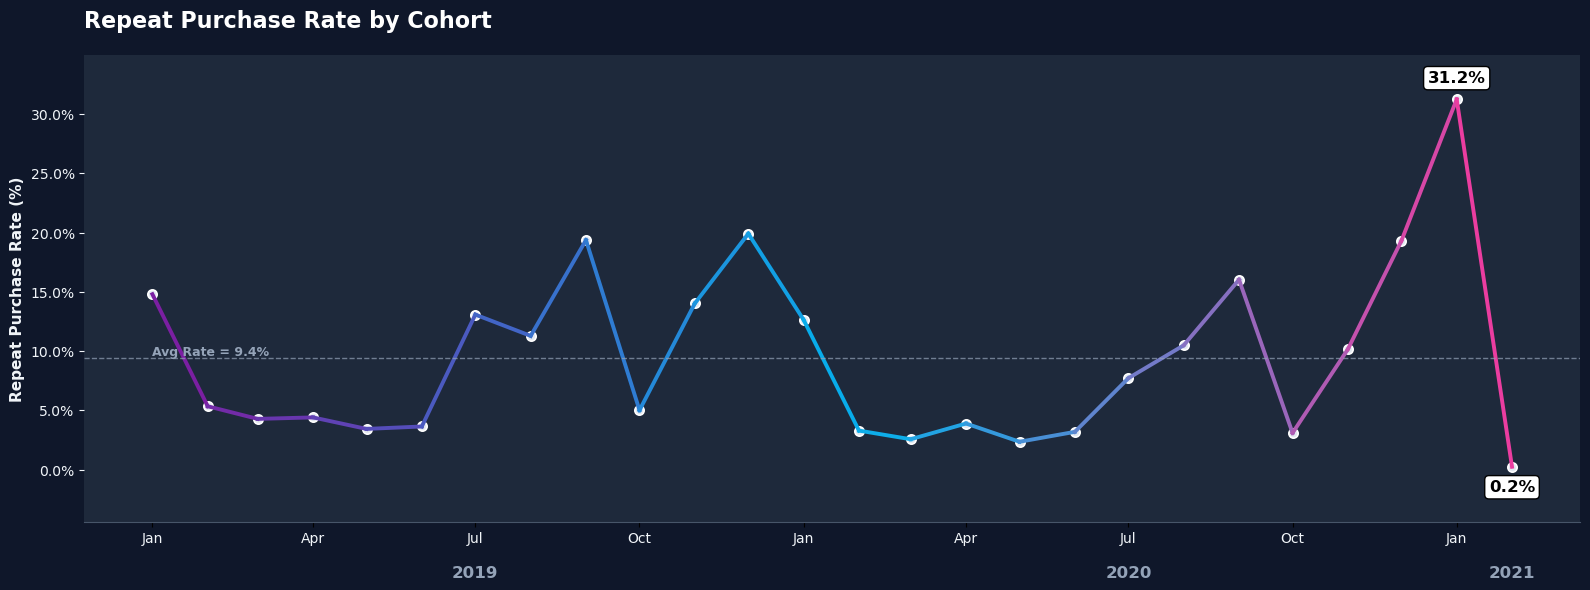

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Prepare data
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify highest and lowest only
highest = rpr.nlargest(1, 'repeat_purchase_rate_%')
lowest = rpr.nsmallest(1, 'repeat_purchase_rate_%')

# Your 3-color palette (Purple → Blue → Pink)
colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# Create gradient colormap for line
cmap = LinearSegmentedColormap.from_list("rpr_grad", colors)

# Normalize for gradient mapping
n = len(rpr)
gradient_colors = [cmap(i / (n - 1)) for i in range(n)]

fig, ax = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig.patch.set_facecolor('#0f172a')
ax.set_facecolor('#1e293b')

# ---- GRADIENT LINE ----
for i in range(n - 1):
    ax.plot(
        rpr["cohort"].iloc[i:i+2],
        rpr["repeat_purchase_rate_%"].iloc[i:i+2],
        color=gradient_colors[i],
        linewidth=2.8
    )

# Markers
ax.scatter(
    rpr["cohort"],
    rpr["repeat_purchase_rate_%"],
    color="#e2e8f0",
    s=45,
    edgecolors="white",
    linewidth=1.2
)

# ---- TITLE ----
ax.set_title(
    "Repeat Purchase Rate by Cohort",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=20
)

ax.set_xlabel("")

# ---- Y-AXIS (VISIBLE) ----
ax.set_ylabel("Repeat Purchase Rate (%)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax.tick_params(axis="y", colors="#f1f5f9")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.1f}%'))

# ---- Quarter Ticks ----
quarter_mask = rpr["cohort"].dt.month.isin([1, 4, 7, 10])
quarter_data = rpr[quarter_mask]

plt.xticks(
    quarter_data["cohort"],
    quarter_data["cohort"].dt.strftime('%b'),
    fontsize=10,
    color="#f1f5f9"
)

# ---- Borders ----
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("#475569")

# ---- Y-range padding ----
ymin, ymax = rpr["repeat_purchase_rate_%"].min(), rpr["repeat_purchase_rate_%"].max()
ax.set_ylim(
    ymin - (ymax - ymin) * 0.15,
    ymax + (ymax - ymin) * 0.12
)

# ---- Avg Rate ----
avg_rate = rpr['repeat_purchase_rate_%'].mean()
ax.axhline(avg_rate, color="#94a3b8", linestyle="--", linewidth=1, alpha=0.7)
ax.text(
    rpr['cohort'].iloc[0],
    avg_rate * 1.02,
    f"Avg Rate = {avg_rate:.1f}%",
    color="#94a3b8",
    fontsize=9,
    fontweight="bold"
)

# ---- Highest & Lowest Labels ----
# Highest
for _, row in highest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=12,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# Lowest
for _, row in lowest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, -18),
        textcoords="offset points",
        ha="center",
        fontsize=12,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# ---- Year labels below chart ----
years = rpr["cohort"].dt.year.unique()
for yr in years:
    yd = rpr[rpr['cohort'].dt.year == yr]
    mid_month = yd["cohort"].iloc[len(yd)//2]
    ax.text(
        mid_month,
        ymin - (ymax - ymin) * 0.30,
        str(yr),
        ha="center",
        fontsize=12,
        fontweight="bold",
        color="#94a3b8"
    )

plt.tight_layout()
plt.show()

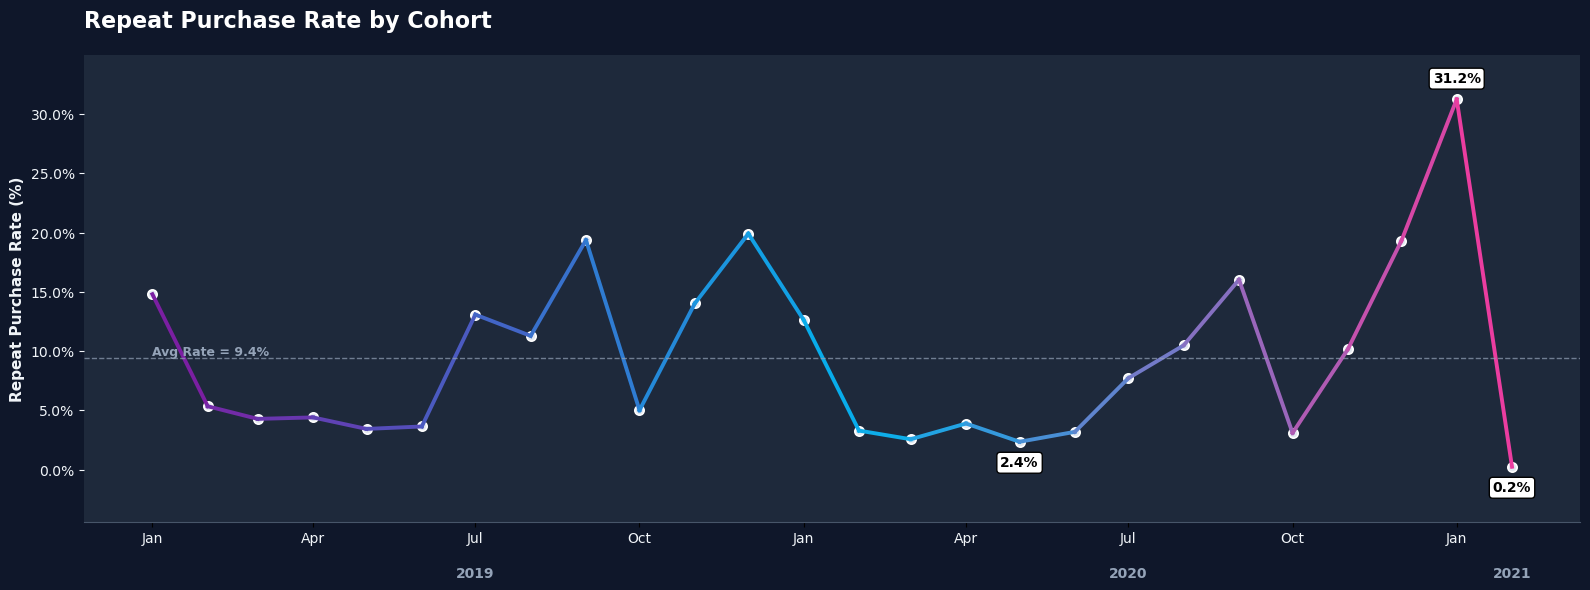

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Prepare data
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify highest, lowest, and 2nd lowest
highest = rpr.nlargest(1, 'repeat_purchase_rate_%')
lowest = rpr.nsmallest(1, 'repeat_purchase_rate_%')
second_lowest = rpr.nsmallest(2, 'repeat_purchase_rate_%').iloc[1:]

# Your 3-color palette (Purple → Blue → Pink)
colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# Create gradient colormap for line
cmap = LinearSegmentedColormap.from_list("rpr_grad", colors)

# Normalize for gradient mapping
n = len(rpr)
gradient_colors = [cmap(i / (n - 1)) for i in range(n)]

fig, ax = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig.patch.set_facecolor('#0f172a')
ax.set_facecolor('#1e293b')

# ---- GRADIENT LINE ----
for i in range(n - 1):
    ax.plot(
        rpr["cohort"].iloc[i:i+2],
        rpr["repeat_purchase_rate_%"].iloc[i:i+2],
        color=gradient_colors[i],
        linewidth=2.8
    )

# Markers
ax.scatter(
    rpr["cohort"],
    rpr["repeat_purchase_rate_%"],
    color="#e2e8f0",
    s=45,
    edgecolors="white",
    linewidth=1.2
)

# ---- TITLE ----
ax.set_title(
    "Repeat Purchase Rate by Cohort",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=20
)

ax.set_xlabel("")

# ---- Y-AXIS (VISIBLE) ----
ax.set_ylabel("Repeat Purchase Rate (%)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax.tick_params(axis="y", colors="#f1f5f9")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.1f}%'))

# ---- Quarter Ticks ----
quarter_mask = rpr["cohort"].dt.month.isin([1, 4, 7, 10])
quarter_data = rpr[quarter_mask]

plt.xticks(
    quarter_data["cohort"],
    quarter_data["cohort"].dt.strftime('%b'),
    fontsize=10,
    color="#f1f5f9"
)

# ---- Borders ----
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("#475569")

# ---- Y-range padding ----
ymin, ymax = rpr["repeat_purchase_rate_%"].min(), rpr["repeat_purchase_rate_%"].max()
ax.set_ylim(
    ymin - (ymax - ymin) * 0.15,
    ymax + (ymax - ymin) * 0.12
)

# ---- Avg Rate ----
avg_rate = rpr['repeat_purchase_rate_%'].mean()
ax.axhline(avg_rate, color="#94a3b8", linestyle="--", linewidth=1, alpha=0.7)
ax.text(
    rpr['cohort'].iloc[0],
    avg_rate * 1.02,
    f"Avg Rate = {avg_rate:.1f}%",
    color="#94a3b8",
    fontsize=9,
    fontweight="bold"
)

# ---- Highest & Lowest & 2nd Lowest Labels ----
# Highest
for _, row in highest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# Lowest
for _, row in lowest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, -18),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# 2nd Lowest
for _, row in second_lowest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.1f}%",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, -18),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# ---- Year labels below chart ----
years = rpr["cohort"].dt.year.unique()
for yr in years:
    yd = rpr[rpr['cohort'].dt.year == yr]
    mid_month = yd["cohort"].iloc[len(yd)//2]
    ax.text(
        mid_month,
        ymin - (ymax - ymin) * 0.30,
        str(yr),
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#94a3b8"
    )

plt.tight_layout()
plt.show()

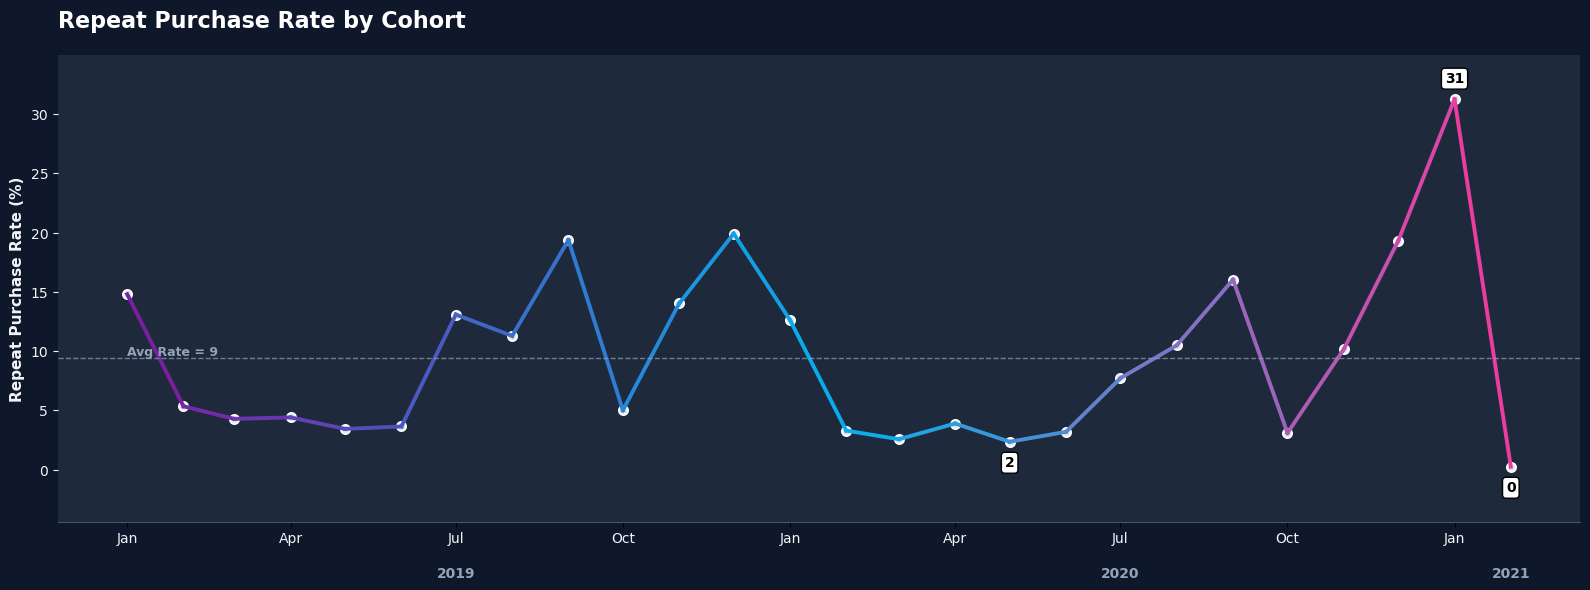

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Prepare data
rpr['cohort'] = pd.to_datetime(rpr['cohort'], format='%Y-%m')
rpr = rpr.sort_values('cohort')

# Identify highest, lowest, and 2nd lowest
highest = rpr.nlargest(1, 'repeat_purchase_rate_%')
lowest = rpr.nsmallest(1, 'repeat_purchase_rate_%')
second_lowest = rpr.nsmallest(2, 'repeat_purchase_rate_%').iloc[1:]

# Your 3-color palette (Purple → Blue → Pink)
colors = ["#7B1FA2", "#03b2ed", "#FF3399"]

# Create gradient colormap for line
cmap = LinearSegmentedColormap.from_list("rpr_grad", colors)

# Normalize for gradient mapping
n = len(rpr)
gradient_colors = [cmap(i / (n - 1)) for i in range(n)]

fig, ax = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig.patch.set_facecolor('#0f172a')
ax.set_facecolor('#1e293b')

# ---- GRADIENT LINE ----
for i in range(n - 1):
    ax.plot(
        rpr["cohort"].iloc[i:i+2],
        rpr["repeat_purchase_rate_%"].iloc[i:i+2],
        color=gradient_colors[i],
        linewidth=2.8
    )

# Markers
ax.scatter(
    rpr["cohort"],
    rpr["repeat_purchase_rate_%"],
    color="#e2e8f0",
    s=45,
    edgecolors="white",
    linewidth=1.2
)

# ---- TITLE ----
ax.set_title(
    "Repeat Purchase Rate by Cohort",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=20
)

ax.set_xlabel("")

# ---- Y-AXIS (VISIBLE) ----
ax.set_ylabel("Repeat Purchase Rate (%)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax.tick_params(axis="y", colors="#f1f5f9")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:.0f}'))

# ---- Quarter Ticks ----
quarter_mask = rpr["cohort"].dt.month.isin([1, 4, 7, 10])
quarter_data = rpr[quarter_mask]

plt.xticks(
    quarter_data["cohort"],
    quarter_data["cohort"].dt.strftime('%b'),
    fontsize=10,
    color="#f1f5f9"
)

# ---- Borders ----
for spine in ["top", "left", "right"]:
    ax.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("#475569")

# ---- Y-range padding ----
ymin, ymax = rpr["repeat_purchase_rate_%"].min(), rpr["repeat_purchase_rate_%"].max()
ax.set_ylim(
    ymin - (ymax - ymin) * 0.15,
    ymax + (ymax - ymin) * 0.12
)

# ---- Avg Rate ----
avg_rate = rpr['repeat_purchase_rate_%'].mean()
ax.axhline(avg_rate, color="#94a3b8", linestyle="--", linewidth=1, alpha=0.7)
ax.text(
    rpr['cohort'].iloc[0],
    avg_rate * 1.02,
    f"Avg Rate = {avg_rate:.0f}",
    color="#94a3b8",
    fontsize=9,
    fontweight="bold"
)

# ---- Highest & Lowest & 2nd Lowest Labels ----
# Highest
for _, row in highest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.0f}",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, 12),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# Lowest
for _, row in lowest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.0f}",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, -18),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# 2nd Lowest
for _, row in second_lowest.iterrows():
    ax.annotate(
        f"{row['repeat_purchase_rate_%']:.0f}",
        xy=(row["cohort"], row["repeat_purchase_rate_%"]),
        xytext=(0, -18),
        textcoords="offset points",
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#000000",
        bbox=dict(boxstyle="round,pad=0.25", edgecolor="black", facecolor="white")
    )

# ---- Year labels below chart ----
years = rpr["cohort"].dt.year.unique()
for yr in years:
    yd = rpr[rpr['cohort'].dt.year == yr]
    mid_month = yd["cohort"].iloc[len(yd)//2]
    ax.text(
        mid_month,
        ymin - (ymax - ymin) * 0.30,
        str(yr),
        ha="center",
        fontsize=10,
        fontweight="bold",
        color="#94a3b8"
    )

plt.tight_layout()
plt.show()

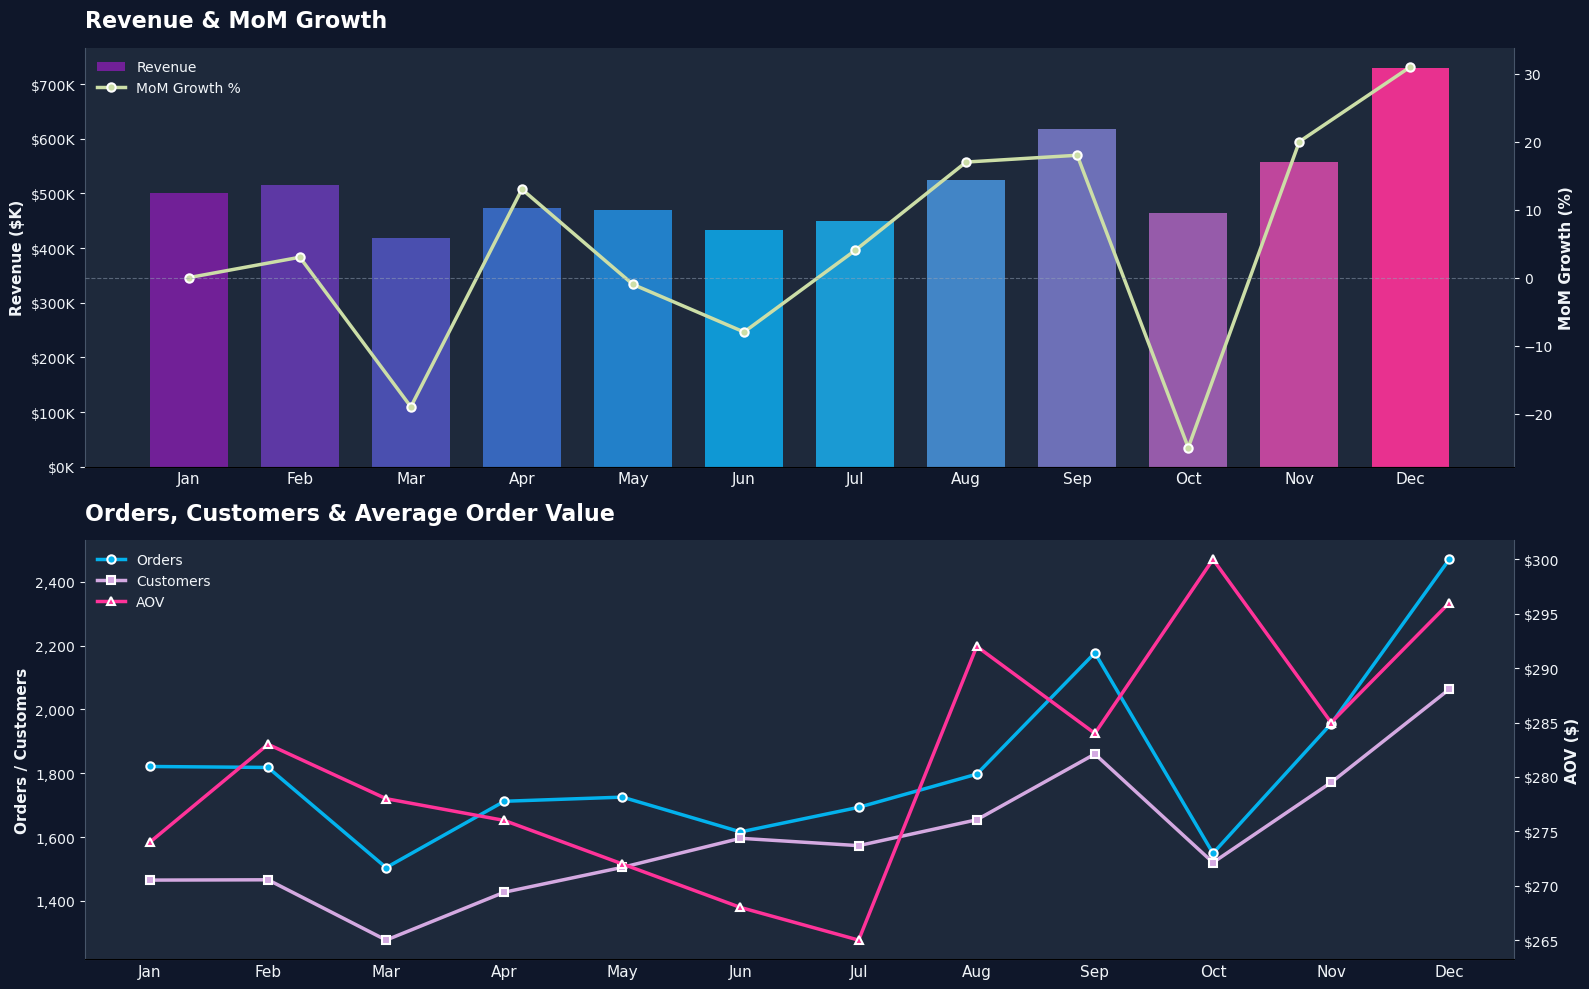

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np

# Data
data = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'revenue': [500, 515, 418, 473, 469, 433, 449, 525, 618, 465, 557, 730],
    'orders': [1821, 1818, 1504, 1712, 1725, 1616, 1693, 1797, 2177, 1549, 1955, 2470],
    'customers': [1465, 1466, 1277, 1427, 1505, 1596, 1573, 1654, 1860, 1520, 1771, 2063],
    'aov': [274, 283, 278, 276, 272, 268, 265, 292, 284, 300, 285, 296],
    'mom': [None, 3, -19, 13, -1, -8, 4, 17, 18, -25, 20, 31]
}

df = pd.DataFrame(data)
x = np.arange(len(df['month']))

# Your 3-color palette
PURPLE = "#7B1FA2"
BLUE = "#03b2ed"
PINK = "#FF3399"
LAVENDER = "#D4A9E1"
LIME = "#CCDEA7"

# Create figure with 2 subplots stacked vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10))

# DARK SLATE/NAVY BACKGROUND
fig.patch.set_facecolor('#0f172a')
ax1.set_facecolor('#1e293b')
ax2.set_facecolor('#1e293b')

# ===== CHART 1: REVENUE & MOM GROWTH =====
# Gradient bars for revenue
from matplotlib.colors import LinearSegmentedColormap
colors = [PURPLE, BLUE, PINK]
cmap = LinearSegmentedColormap.from_list("revenue_grad", colors)
n = len(df)
bar_colors = [cmap(i / (n - 1)) for i in range(n)]

# Revenue bars
bars = ax1.bar(x, df['revenue'], color=bar_colors, alpha=0.9, width=0.7, label='Revenue')

# MoM Growth line (secondary axis)
ax1_right = ax1.twinx()
mom_data = df['mom'].fillna(0)
ax1_right.plot(x, mom_data, color=LIME, marker='o', markersize=6, 
               markeredgecolor="white", linewidth=2.5, label='MoM Growth %', markeredgewidth=1.5)

# Title
ax1.set_title(
    "Revenue & MoM Growth",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=15
)

# X-axis
ax1.set_xticks(x)
ax1.set_xticklabels(df['month'], fontsize=11, color="#f1f5f9")
ax1.tick_params(axis='x', length=0)

# Y-axis (Revenue)
ax1.set_ylabel("Revenue ($K)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax1.tick_params(axis="y", colors="#f1f5f9")
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:.0f}K'))

# Y-axis (MoM %)
ax1_right.set_ylabel("MoM Growth (%)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax1_right.tick_params(axis="y", colors="#f1f5f9")
ax1_right.axhline(0, color="#94a3b8", linestyle="--", linewidth=0.8, alpha=0.5)

# Spines
for spine in ["top"]:
    ax1.spines[spine].set_visible(False)
    ax1_right.spines[spine].set_visible(False)
ax1.spines["bottom"].set_color("#475569")
ax1.spines["left"].set_color("#475569")
ax1.spines["right"].set_visible(False)
ax1_right.spines["right"].set_color("#475569")
ax1_right.spines["left"].set_visible(False)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_right.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc="upper left", fontsize=10, frameon=False, labelcolor="#f1f5f9")

# ===== CHART 2: ORDERS, CUSTOMERS & AOV =====
# Secondary axis for AOV
ax2_right = ax2.twinx()

# Orders line
ax2.plot(x, df['orders'], color=BLUE, marker='o', markersize=6, 
         markeredgecolor="white", linewidth=2.5, label='Orders', markeredgewidth=1.5)

# Customers line
ax2.plot(x, df['customers'], color=LAVENDER, marker='s', markersize=6, 
         markeredgecolor="white", linewidth=2.5, label='Customers', markeredgewidth=1.5)

# AOV line (on secondary axis)
ax2_right.plot(x, df['aov'], color=PINK, marker='^', markersize=6, 
               markeredgecolor="white", linewidth=2.5, label='AOV', markeredgewidth=1.5)

# Title
ax2.set_title(
    "Orders, Customers & Average Order Value",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=15
)

# X-axis
ax2.set_xticks(x)
ax2.set_xticklabels(df['month'], fontsize=11, color="#f1f5f9")
ax2.tick_params(axis='x', length=0)

# Y-axis (Orders/Customers)
ax2.set_ylabel("Orders / Customers", color="#f1f5f9", fontsize=11, fontweight='bold')
ax2.tick_params(axis="y", colors="#f1f5f9")
ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Y-axis (AOV)
ax2_right.set_ylabel("AOV ($)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax2_right.tick_params(axis="y", colors="#f1f5f9")
ax2_right.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:.0f}'))

# Spines
for spine in ["top"]:
    ax2.spines[spine].set_visible(False)
    ax2_right.spines[spine].set_visible(False)
ax2.spines["bottom"].set_color("#475569")
ax2.spines["left"].set_color("#475569")
ax2.spines["right"].set_visible(False)
ax2_right.spines["right"].set_color("#475569")
ax2_right.spines["left"].set_visible(False)

# Legend
lines3, labels3 = ax2.get_legend_handles_labels()
lines4, labels4 = ax2_right.get_legend_handles_labels()
ax2.legend(lines3 + lines4, labels3 + labels4, 
          loc="upper left", fontsize=10, frameon=False, labelcolor="#f1f5f9")

plt.tight_layout()
plt.show()

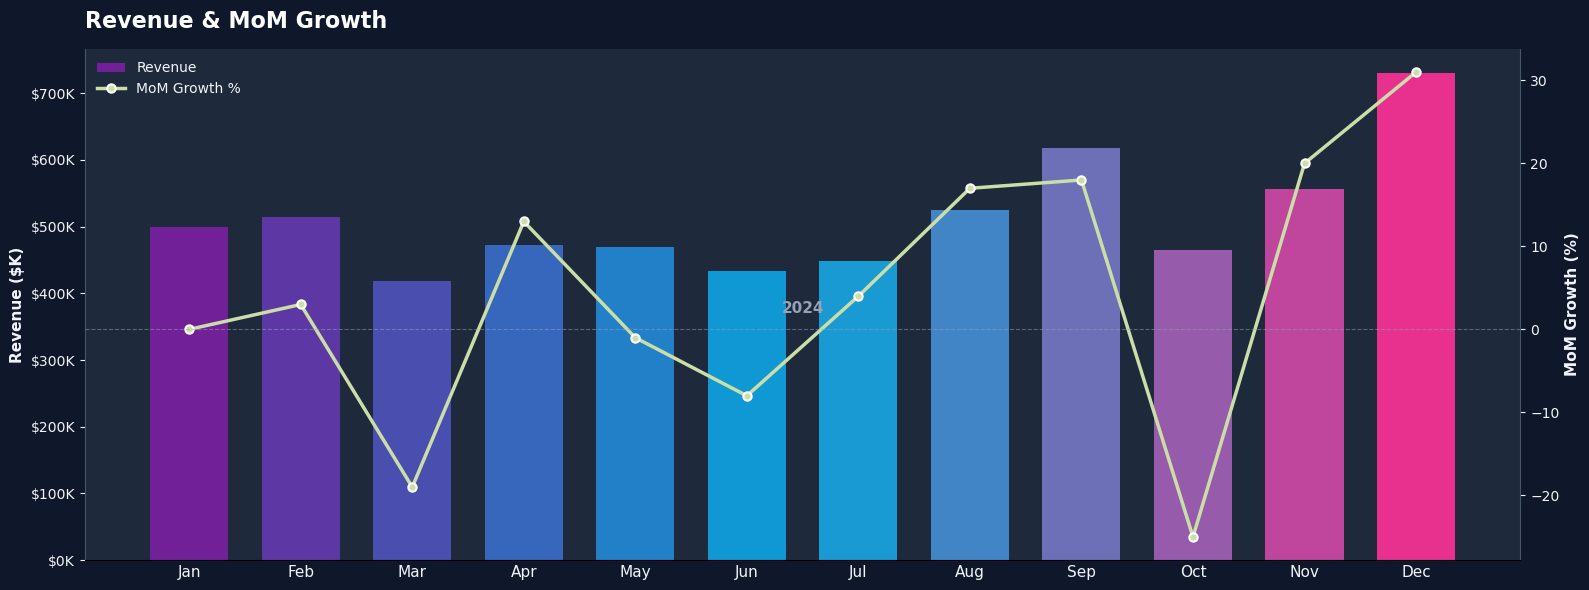

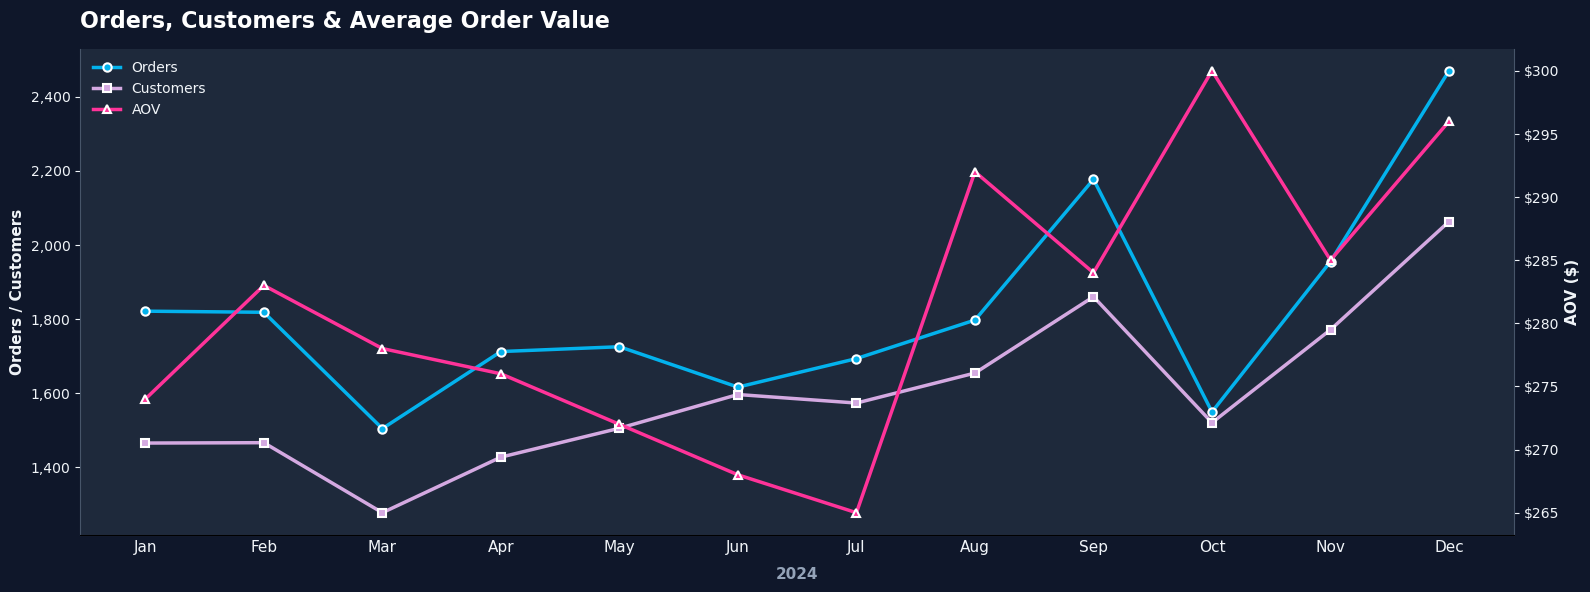

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Data
data = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'revenue': [500, 515, 418, 473, 469, 433, 449, 525, 618, 465, 557, 730],
    'orders': [1821, 1818, 1504, 1712, 1725, 1616, 1693, 1797, 2177, 1549, 1955, 2470],
    'customers': [1465, 1466, 1277, 1427, 1505, 1596, 1573, 1654, 1860, 1520, 1771, 2063],
    'aov': [274, 283, 278, 276, 272, 268, 265, 292, 284, 300, 285, 296],
    'mom': [None, 3, -19, 13, -1, -8, 4, 17, 18, -25, 20, 31]
}

df = pd.DataFrame(data)
x = np.arange(len(df['month']))

# Your 3-color palette
PURPLE = "#7B1FA2"
BLUE = "#03b2ed"
PINK = "#FF3399"
LAVENDER = "#D4A9E1"
LIME = "#CCDEA7"

# ===== CHART 1: REVENUE & MOM GROWTH =====
fig1, ax1 = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig1.patch.set_facecolor('#0f172a')
ax1.set_facecolor('#1e293b')

# Gradient bars for revenue
colors = [PURPLE, BLUE, PINK]
cmap = LinearSegmentedColormap.from_list("revenue_grad", colors)
n = len(df)
bar_colors = [cmap(i / (n - 1)) for i in range(n)]

# Revenue bars
bars = ax1.bar(x, df['revenue'], color=bar_colors, alpha=0.9, width=0.7, label='Revenue')

# MoM Growth line (secondary axis)
ax1_right = ax1.twinx()
mom_data = df['mom'].fillna(0)
ax1_right.plot(x, mom_data, color=LIME, marker='o', markersize=6, 
               markeredgecolor="white", linewidth=2.5, label='MoM Growth %', markeredgewidth=1.5)

# Title
ax1.set_title(
    "Revenue & MoM Growth",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=15
)

# X-axis
ax1.set_xticks(x)
ax1.set_xticklabels(df['month'], fontsize=11, color="#f1f5f9")
ax1.tick_params(axis='x', length=0)

# Y-axis (Revenue)
ax1.set_ylabel("Revenue ($K)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax1.tick_params(axis="y", colors="#f1f5f9")
ax1.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:.0f}K'))

# Y-axis (MoM %)
ax1_right.set_ylabel("MoM Growth (%)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax1_right.tick_params(axis="y", colors="#f1f5f9")
ax1_right.axhline(0, color="#94a3b8", linestyle="--", linewidth=0.8, alpha=0.5)

# Spines
for spine in ["top"]:
    ax1.spines[spine].set_visible(False)
    ax1_right.spines[spine].set_visible(False)
ax1.spines["bottom"].set_color("#475569")
ax1.spines["left"].set_color("#475569")
ax1.spines["right"].set_visible(False)
ax1_right.spines["right"].set_color("#475569")
ax1_right.spines["left"].set_visible(False)

# Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax1_right.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, 
          loc="upper left", fontsize=10, frameon=False, labelcolor="#f1f5f9")

# Year label below chart
ymin = min(df['revenue'])
ymax = max(df['revenue'])
ax1.text(
    len(df) / 2 - 0.5,
    ymin - (ymax - ymin) * 0.15,
    "2024",
    ha="center",
    fontsize=11,
    fontweight="bold",
    color="#94a3b8"
)

plt.tight_layout()
plt.show()

# ===== CHART 2: ORDERS, CUSTOMERS & AOV =====
fig2, ax2 = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig2.patch.set_facecolor('#0f172a')
ax2.set_facecolor('#1e293b')

# Secondary axis for AOV
ax2_right = ax2.twinx()

# Orders line
ax2.plot(x, df['orders'], color=BLUE, marker='o', markersize=6, 
         markeredgecolor="white", linewidth=2.5, label='Orders', markeredgewidth=1.5)

# Customers line
ax2.plot(x, df['customers'], color=LAVENDER, marker='s', markersize=6, 
         markeredgecolor="white", linewidth=2.5, label='Customers', markeredgewidth=1.5)

# AOV line (on secondary axis)
ax2_right.plot(x, df['aov'], color=PINK, marker='^', markersize=6, 
               markeredgecolor="white", linewidth=2.5, label='AOV', markeredgewidth=1.5)

# Title
ax2.set_title(
    "Orders, Customers & Average Order Value",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=15
)

# X-axis
ax2.set_xticks(x)
ax2.set_xticklabels(df['month'], fontsize=11, color="#f1f5f9")
ax2.tick_params(axis='x', length=0)

# Y-axis (Orders/Customers)
ax2.set_ylabel("Orders / Customers", color="#f1f5f9", fontsize=11, fontweight='bold')
ax2.tick_params(axis="y", colors="#f1f5f9")
ax2.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Y-axis (AOV)
ax2_right.set_ylabel("AOV ($)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax2_right.tick_params(axis="y", colors="#f1f5f9")
ax2_right.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:.0f}'))

# Spines
for spine in ["top"]:
    ax2.spines[spine].set_visible(False)
    ax2_right.spines[spine].set_visible(False)
ax2.spines["bottom"].set_color("#475569")
ax2.spines["left"].set_color("#475569")
ax2.spines["right"].set_visible(False)
ax2_right.spines["right"].set_color("#475569")
ax2_right.spines["left"].set_visible(False)

# Legend
lines3, labels3 = ax2.get_legend_handles_labels()
lines4, labels4 = ax2_right.get_legend_handles_labels()
ax2.legend(lines3 + lines4, labels3 + labels4, 
          loc="upper left", fontsize=10, frameon=False, labelcolor="#f1f5f9")

# Year label below chart
ymin2 = min(min(df['orders']), min(df['customers']))
ymax2 = max(max(df['orders']), max(df['customers']))
ax2.text(
    len(df) / 2 - 0.5,
    ymin2 - (ymax2 - ymin2) * 0.15,
    "2024",
    ha="center",
    fontsize=11,
    fontweight="bold",
    color="#94a3b8"
)

plt.tight_layout()
plt.show()

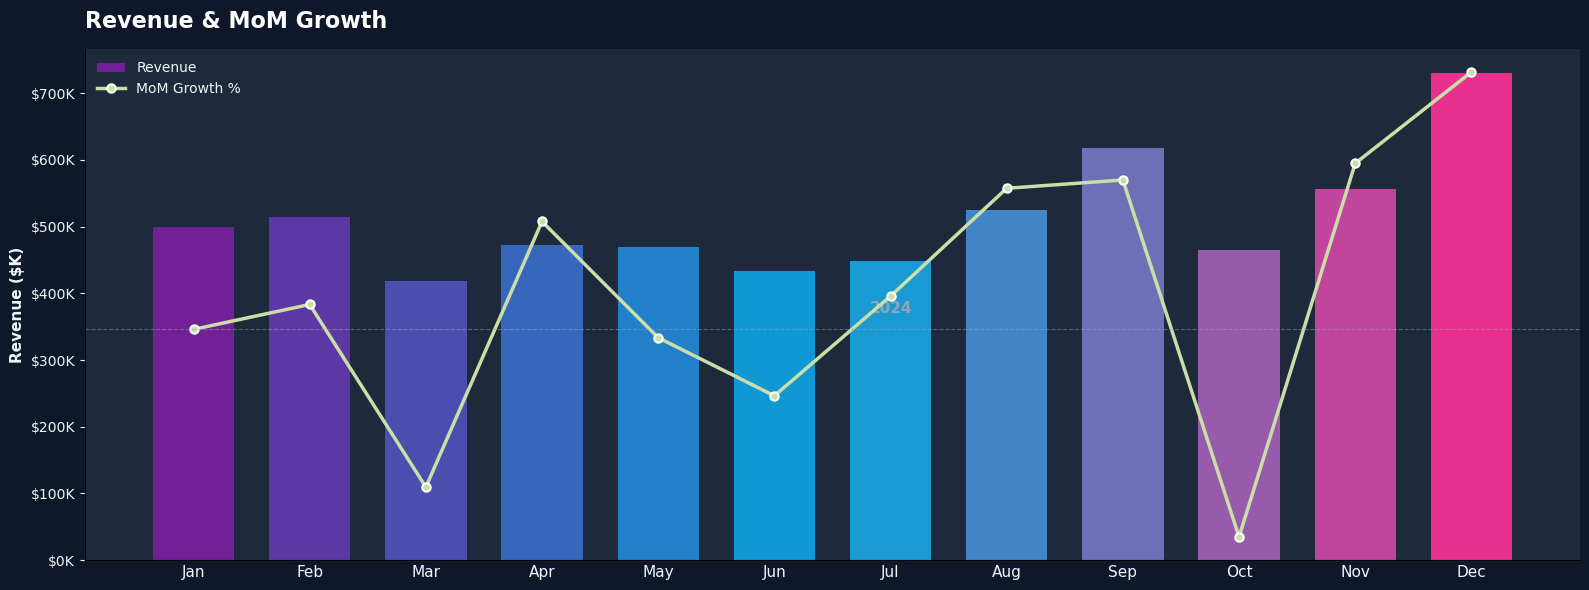

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Data
data = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'year': [2024] * 12,
    'revenue': [500, 515, 418, 473, 469, 433, 449, 525, 618, 465, 557, 730],
    'mom': [None, 3, -19, 13, -1, -8, 4, 17, 18, -25, 20, 31]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%b')
x = np.arange(len(df['month']))

# Your 3-color palette
PURPLE = "#7B1FA2"
BLUE = "#03b2ed"
PINK = "#FF3399"
LIME = "#CCDEA7"

# ===== CHART: REVENUE & MOM GROWTH =====
fig, ax = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig.patch.set_facecolor('#0f172a')
ax.set_facecolor('#1e293b')

# Gradient bars for revenue
colors = [PURPLE, BLUE, PINK]
cmap = LinearSegmentedColormap.from_list("revenue_grad", colors)
n = len(df)
bar_colors = [cmap(i / (n - 1)) for i in range(n)]

# Revenue bars
bars = ax.bar(x, df['revenue'], color=bar_colors, alpha=0.9, width=0.7, label='Revenue')

# MoM Growth line (secondary axis)
ax_right = ax.twinx()
mom_data = df['mom'].fillna(0)
ax_right.plot(x, mom_data, color=LIME, marker='o', markersize=6, 
               markeredgecolor="white", linewidth=2.5, label='MoM Growth %', markeredgewidth=1.5)

# Title
ax.set_title(
    "Revenue & MoM Growth",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=15
)

# X-axis
ax.set_xticks(x)
ax.set_xticklabels(df['month'], fontsize=11, color="#f1f5f9")
ax.tick_params(axis='x', length=0)

# Y-axis (Revenue)
ax.set_ylabel("Revenue ($K)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax.tick_params(axis="y", colors="#f1f5f9")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:.0f}K'))

# Hide Y-axis for MoM % (right side)
ax_right.yaxis.set_visible(False)
ax_right.axhline(0, color="#94a3b8", linestyle="--", linewidth=0.8, alpha=0.5)

# Spines
for spine in ["top", "right"]:
    ax.spines[spine].set_visible(False)
    ax_right.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("#475569")
ax.spines["left"].set_color("#475569")

# Legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, 
          loc="upper left", fontsize=10, frameon=False, labelcolor="#f1f5f9")

# ---- Year labels below chart ----
years = df["date"].dt.year.unique()
ymin = df['revenue'].min()
ymax = df['revenue'].max()

for yr in years:
    yd = df[df['date'].dt.year == yr]
    mid_index = x[yd.index[len(yd)//2]]
    ax.text(
        mid_index,
        ymin - (ymax - ymin) * 0.15,
        str(yr),
        ha="center",
        fontsize=11,
        fontweight="bold",
        color="#94a3b8"
    )

plt.tight_layout()
plt.show()

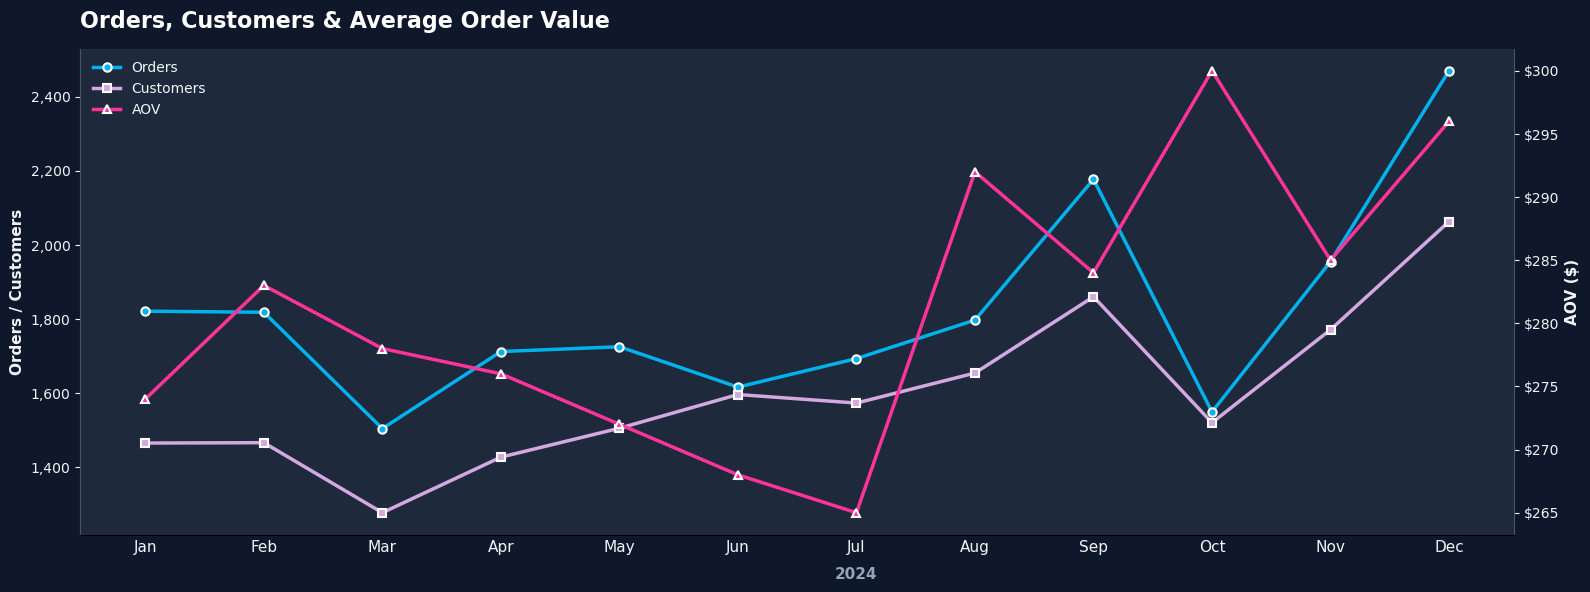

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np

# Data
data = {
    'month': ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
    'year': [2024] * 12,
    'orders': [1821, 1818, 1504, 1712, 1725, 1616, 1693, 1797, 2177, 1549, 1955, 2470],
    'customers': [1465, 1466, 1277, 1427, 1505, 1596, 1573, 1654, 1860, 1520, 1771, 2063],
    'aov': [274, 283, 278, 276, 272, 268, 265, 292, 284, 300, 285, 296]
}

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'], format='%Y-%b')
x = np.arange(len(df['month']))

# Your 3-color palette
PURPLE = "#7B1FA2"
BLUE = "#03b2ed"
PINK = "#FF3399"
LAVENDER = "#D4A9E1"

# ===== CHART: ORDERS, CUSTOMERS & AOV =====
fig, ax = plt.subplots(figsize=(16, 6))

# DARK SLATE/NAVY BACKGROUND
fig.patch.set_facecolor('#0f172a')
ax.set_facecolor('#1e293b')

# Secondary axis for AOV
ax_right = ax.twinx()

# Orders line
ax.plot(x, df['orders'], color=BLUE, marker='o', markersize=6, 
         markeredgecolor="white", linewidth=2.5, label='Orders', markeredgewidth=1.5)

# Customers line
ax.plot(x, df['customers'], color=LAVENDER, marker='s', markersize=6, 
         markeredgecolor="white", linewidth=2.5, label='Customers', markeredgewidth=1.5)

# AOV line (on secondary axis)
ax_right.plot(x, df['aov'], color=PINK, marker='^', markersize=6, 
               markeredgecolor="white", linewidth=2.5, label='AOV', markeredgewidth=1.5)

# Title
ax.set_title(
    "Orders, Customers & Average Order Value",
    fontsize=16,
    fontweight="bold",
    loc="left",
    color="white",
    pad=15
)

# X-axis
ax.set_xticks(x)
ax.set_xticklabels(df['month'], fontsize=11, color="#f1f5f9")
ax.tick_params(axis='x', length=0)

# Y-axis (Orders/Customers)
ax.set_ylabel("Orders / Customers", color="#f1f5f9", fontsize=11, fontweight='bold')
ax.tick_params(axis="y", colors="#f1f5f9")
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Y-axis (AOV)
ax_right.set_ylabel("AOV ($)", color="#f1f5f9", fontsize=11, fontweight='bold')
ax_right.tick_params(axis="y", colors="#f1f5f9")
ax_right.yaxis.set_major_formatter(mticker.StrMethodFormatter('${x:.0f}'))

# Spines
for spine in ["top"]:
    ax.spines[spine].set_visible(False)
    ax_right.spines[spine].set_visible(False)
ax.spines["bottom"].set_color("#475569")
ax.spines["left"].set_color("#475569")
ax.spines["right"].set_visible(False)
ax_right.spines["right"].set_color("#475569")
ax_right.spines["left"].set_visible(False)

# Legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax_right.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, 
          loc="upper left", fontsize=10, frameon=False, labelcolor="#f1f5f9")

# ---- Year labels below chart ----
years = df["date"].dt.year.unique()
ymin = min(min(df['orders']), min(df['customers']))
ymax = max(max(df['orders']), max(df['customers']))

for yr in years:
    yd = df[df['date'].dt.year == yr]
    mid_index = x[yd.index[len(yd)//2]]
    ax.text(
        mid_index,
        ymin - (ymax - ymin) * 0.15,
        str(yr),
        ha="center",
        fontsize=11,
        fontweight="bold",
        color="#94a3b8"
    )

plt.tight_layout()
plt.show()

In [20]:
rpr

,cohort,repeat_purchase_rate_%
0,2019-01-01,14.797136
1,2019-02-01,5.345912
2,2019-03-01,4.280156
3,2019-04-01,4.406130
4,2019-05-01,3.434343
5,2019-06-01,3.640257
6,2019-07-01,13.078471
7,2019-08-01,11.284047
8,2019-09-01,19.366197
9,2019-10-01,5.010438
